# Modelos
Se crean varios modelos de diferentes tipos. El modelo A predice el diagnóstico de diabetes (0 o 1). Además, se crea el C. Una predicción de riesgo de diabetes quitando las glucosas. No se debe usar como diagnóstico, sino como una herramienta de predicción según los hábitos. Es posible que el 'diabetes risk score' haya sido calculado con la glucosa, así que también hemos decidido quitarlo.

En un futuro se podría añadir un modelo B para el diagnóstico de tipo de diabetes. Un diagnóstico en cascada en el que se calcula la predicción del tipo únicamente a las personas que lo tienen.

# Preparación del dataset

##Importación del dataset


https://www.kaggle.com/datasets/mohankrishnathalla/diabetes-health-indicators-dataset/data

In [ ]:
pip install catboost

In [ ]:
!pip install lightgbm

In [ ]:
#Importación de librerías

#manipulación de datos, df
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math

#modelos
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree

from sklearn.model_selection import RandomizedSearchCV, train_test_split, cross_validate

import joblib

#evaluacion
from sklearn.metrics import precision_score, recall_score, accuracy_score, confusion_matrix, f1_score
from sklearn.metrics import recall_score, classification_report, precision_recall_curve
from sklearn.metrics import RocCurveDisplay

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
import lightgbm as lgb


In [ ]:
#Importación del csv
!wget https://raw.githubusercontent.com/Alferez36/Inteligencia-Artificial/refs/heads/main/diabetes_dataset.csv

--2026-01-24 17:01:28--  https://raw.githubusercontent.com/Alferez36/Inteligencia-Artificial/refs/heads/main/diabetes_dataset.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14365521 (14M) [text/plain]
Saving to: ‘diabetes_dataset.csv’

diabetes_dataset.cs 100%[===================>]  13.70M  --.-KB/s    in 0.09s   

2026-01-24 17:01:29 (159 MB/s) - ‘diabetes_dataset.csv’ saved [14365521/14365521]



In [ ]:
df = pd.read_csv('diabetes_dataset.csv')
df.head()

,age,gender,ethnicity,education_level,income_level,employment_status,smoking_status,alcohol_consumption_per_week,physical_activity_minutes_per_week,diet_score,...,hdl_cholesterol,ldl_cholesterol,triglycerides,glucose_fasting,glucose_postprandial,insulin_level,hba1c,diabetes_risk_score,diabetes_stage,diagnosed_diabetes
0,58,Male,Asian,Highschool,Lower-Middle,Employed,Never,0,215,5.7,...,41,160,145,136,236,6.36,8.18,29.6,Type 2,1
1,48,Female,White,Highschool,Middle,Employed,Former,1,143,6.7,...,55,50,30,93,150,2.00,5.63,23.0,No Diabetes,0
2,60,Male,Hispanic,Highschool,Middle,Unemployed,Never,1,57,6.4,...,66,99,36,118,195,5.07,7.51,44.7,Type 2,1
3,74,Female,Black,Highschool,Low,Retired,Never,0,49,3.4,...,50,79,140,139,253,5.28,9.03,38.2,Type 2,1
4,46,Male,White,Graduate,Middle,Retired,Never,1,109,7.2,...,52,125,160,137,184,12.74,7.20,23.5,Type 2,1


División del dataset en training (80%) y testing (20%).

In [ ]:
X = df.drop(['diagnosed_diabetes', 'diabetes_stage'], axis=1)
yA = df['diagnosed_diabetes']

X_train_A, X_test_A, y_train_A, y_test_A = train_test_split(X, yA, test_size=0.2, stratify=yA, random_state=42)

XC = df.drop(['hba1c', 'glucose_postprandial', 'glucose_fasting', 'insulin_level', 'diagnosed_diabetes', 'diabetes_stage', 'diabetes_risk_score'], axis=1)
yC = df['diagnosed_diabetes']
X_train_C, X_test_C, y_train_C, y_test_C = train_test_split(XC, yC, test_size=0.2, stratify=yC, random_state=42)

## Codificación

Algunos de los algortimos que vamos a utilizar no admiten texto. Para las categorías nominales (sin orden intrínseco de importancia) aplicaremos One-Hot encoding (codificación en caliente) y para las categorías ordinales, codificación ordinal.

Para los modelos no basados en árboles es importante que todas las características estén en la misma escala. Para esto se ha utilizado StandardScaler. Es importante remarcar que únicamente se ha realizado este proceso a las categorías numéricas.

Los modelos basados en árboles no necesitan de escalado. Sin embargo, hemos aplicado el mismo pipeline para mantener una coherencia metedeológica en los tres.

In [ ]:
#División según tipo de variable para el modelo A
# Numéricas
cols_num = [
    'age', 'alcohol_consumption_per_week', 'physical_activity_minutes_per_week',
    'diet_score', 'sleep_hours_per_day', 'screen_time_hours_per_day', 'bmi',
    'waist_to_hip_ratio', 'systolic_bp', 'diastolic_bp', 'heart_rate',
    'cholesterol_total', 'hdl_cholesterol', 'ldl_cholesterol', 'triglycerides',
    'glucose_fasting', 'glucose_postprandial', 'insulin_level', 'hba1c',
    'diabetes_risk_score'
]

# Nominales (sin orden)
cols_cat= [
    'gender', 'ethnicity', 'employment_status'
]

# Ordinales (con orden)
cols_ordinal = [
    'education_level', 'income_level', 'smoking_status'
]

education_order = ['No formal', 'Highschool', 'Graduate', 'Postgraduate']
income_order = ['Low', 'Lower-Middle', 'Middle', 'Upper-Middle', 'High']
smoking_order = ['Never', 'Former', 'Current']

#Binarias
cols_bin = [
    'family_history_diabetes', 'hypertension_history',
    'cardiovascular_history'
]

#Otra
id_col = ['patient_id']


#División según el tipo de variable para el modelo C
cols_num_C = [col for col in cols_num if col in XC.columns]
cols_cat_C = [col for col in cols_cat if col in XC.columns]
cols_ord_C = [col for col in cols_ordinal if col in XC.columns]
cols_bin_C = [col for col in cols_bin if col in XC.columns]

In [ ]:
#Modelo A
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), cols_num),
        ('cat', OneHotEncoder(drop='first'), cols_cat),
        ('ord', OrdinalEncoder(categories=[
            education_order,
            income_order,
            smoking_order
        ]), cols_ordinal),
        ('bin', 'passthrough', cols_bin)
    ]
)

pipeline_preprocess = Pipeline(steps=[
    ('preprocessor', preprocessor)
])

#Modelo C
preprocessor_C = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), cols_num_C),
        ('cat', OneHotEncoder(drop='first'), cols_cat_C),
        ('ord', OrdinalEncoder(categories=[
            education_order,
            income_order,
            smoking_order
        ]), cols_ord_C),
        ('bin', 'passthrough', cols_bin_C)
    ]
)

pipeline_preprocess_C = Pipeline(steps=[
    ('preprocessor', preprocessor_C)
])

In [ ]:
pipeline_preprocess.fit(X_train_A) #solo para el entrenamiento para evitar fuga de datos

X_train_A_p = pipeline_preprocess.transform(X_train_A)
X_test_A_p = pipeline_preprocess.transform(X_test_A)

pipeline_preprocess_C.fit(X_train_C)

X_train_C_p = pipeline_preprocess_C.transform(X_train_C)
X_test_C_p = pipeline_preprocess_C.transform(X_test_C)

# Técnicas de evaluación de los modelos

In [ ]:
def matriz(y_test_, y_pred_model):
  matrix = confusion_matrix(y_test_, y_pred_model)
  plt.figure(figsize=(8, 6))
  sns.heatmap(matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['No Diabetes', 'Diabetes'], yticklabels=['No Diabetes', 'Diabetes'])
  plt.xlabel('Predicción')
  plt.ylabel('Realidad')
  plt.show()

In [ ]:
def metricas(nombre, y_true, y_pred):
    return {
        'Modelo': nombre,
        'Accuracy': accuracy_score(y_true, y_pred),
        'Precision (C1)': precision_score(y_true, y_pred),
        'Recall (C1)': recall_score(y_true, y_pred),
        'F1-Score (C1)': f1_score(y_true, y_pred)
    }

# Modelo A: Diagnóstico

## Random Forest
https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html  
Clasificación de variables en aprendizaje supervisado. Construye árboles de decisiones con las predicciones de otros modelos y cada uno genera su propia respuesta. La respuesta final es la que en la mayoría de árboles están de acuerdo.

In [ ]:
#Entrenamiento del modelo (100 árboles de decisión)
forest = RandomForestClassifier(n_estimators=100, random_state=42)
forest.fit(X_train_A_p, y_train_A)
y_pred_A_forest = forest.predict(X_test_A_p)

In [ ]:
print(classification_report(y_test_A,y_pred_A_forest))

              precision    recall  f1-score   support

           0       0.83      1.00      0.91      8000
           1       1.00      0.87      0.93     12000

    accuracy                           0.92     20000
   macro avg       0.92      0.93      0.92     20000
weighted avg       0.93      0.92      0.92     20000



El texto predice correctamente el 92% de las veces. Tiene una puntuación F1 mayor al 90%.   

Una precisión y recall del 1.00 puede significar que haya un sobreajuste de los datos o una característica altamente significativa.

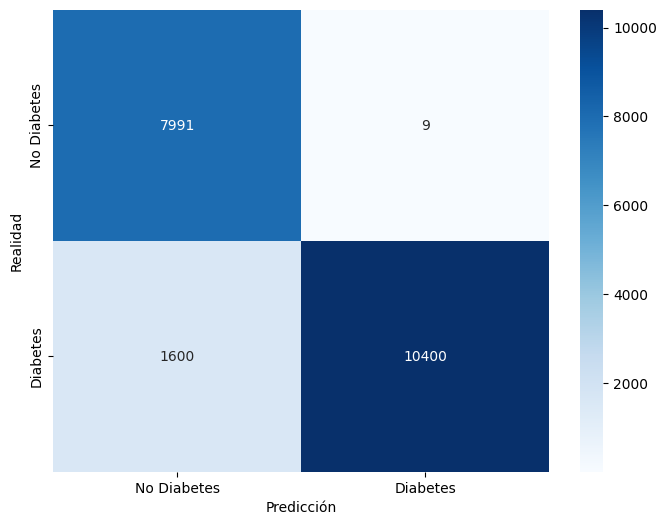

In [ ]:
matriz(y_test_A, y_pred_A_forest)

Descubrimos que la precision para la clase 0 es de 1.00 porque no hay  falsos positivos. Sin embargo, hay 1601 falsos negativos. Da bastantes falsos positivos y muy pocos falsos negativos. Como vimos en el EDA, el 59.998 % estaban diagnosticados con diabetes y 40.002 % no. Por tanto, este problema no se debe a un desbalance de los datos.


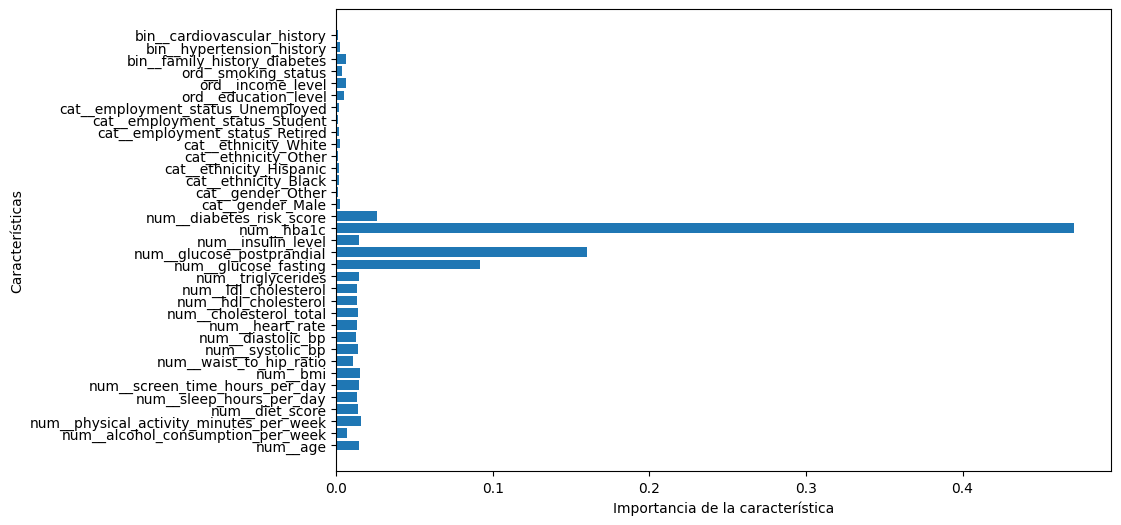

In [ ]:
feature_names_A = pipeline_preprocess.named_steps['preprocessor'].get_feature_names_out()
feature_importances = forest.feature_importances_

plt.figure(figsize=(10,6))

plt.barh(feature_names_A, feature_importances)

plt.xlabel('Importancia de la característica')
plt.ylabel('Características')
plt.show()

Las columnas que más importancia tienen en la predicción para RandomForest son los tres tipos de glucosa (glicada, basal y postpandrial). Esto tiene sentido ya que se suele diagnosticar mayoritariamente con estas variables.

Por lo tanto, este modelo es útil para un diagnóstico médico en gran volumen de datos.

 Sin embargo, si el interés fuera descubrir quién tendrá diabetes en el futuro en base a su estilo de vida, se deberían quitar los tres tipos de glucosa (MODELO C).

### Ajuste de hiperparámetros
Utilizamos RandomizedSearchCV para encontrar los mejores parámetros.

In [ ]:
forest = RandomForestClassifier(random_state=42)

param_dist = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'class_weight': ['balanced', None]
}

random_search = RandomizedSearchCV(
    estimator=forest,
    param_distributions=param_dist,
    n_iter=10,
    cv=3,
    n_jobs=-1,
    scoring='f1',
    verbose=2,
    random_state=42
)

random_search.fit(X_train_A_p, y_train_A)

print(f"\nMejores parámetros encontrados: {random_search.best_params_}")

Fitting 3 folds for each of 10 candidates, totalling 30 fits

Mejores parámetros encontrados: {'n_estimators': 200, 'min_samples_split': 5, 'max_depth': 10, 'class_weight': None}


El recall de la clase 2 ha subido dos puntos, es decir, que hay menos falsos negativos.

In [ ]:
best_forest = RandomForestClassifier(**random_search.best_params_, random_state=42)
best_forest.fit(X_train_A_p, y_train_A)

y_pred_best_forest = best_forest.predict(X_test_A_p)

In [ ]:
print(classification_report(y_test_A, y_pred_best_forest))

              precision    recall  f1-score   support

           0       0.83      1.00      0.91      8000
           1       1.00      0.87      0.93     12000

    accuracy                           0.92     20000
   macro avg       0.92      0.93      0.92     20000
weighted avg       0.93      0.92      0.92     20000



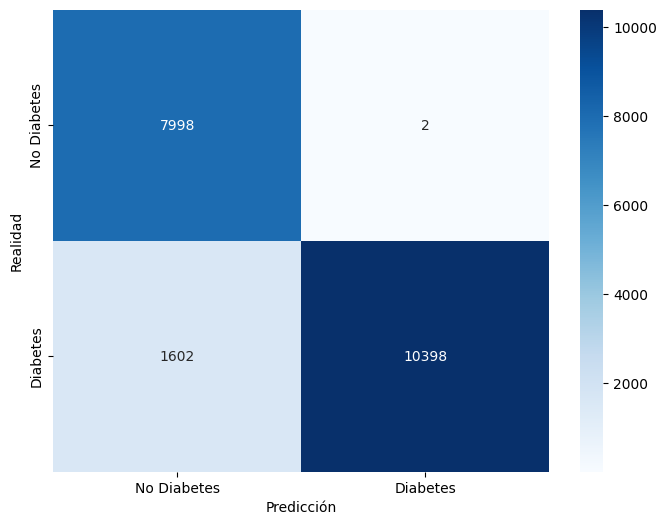

In [ ]:
matriz(y_test_A, y_pred_best_forest)

Una manera de minimizar los falsos negativos es ajustar el umbral de decisión. Por defecto es 0.5, lo bajamos para aumentar el número de positivos.

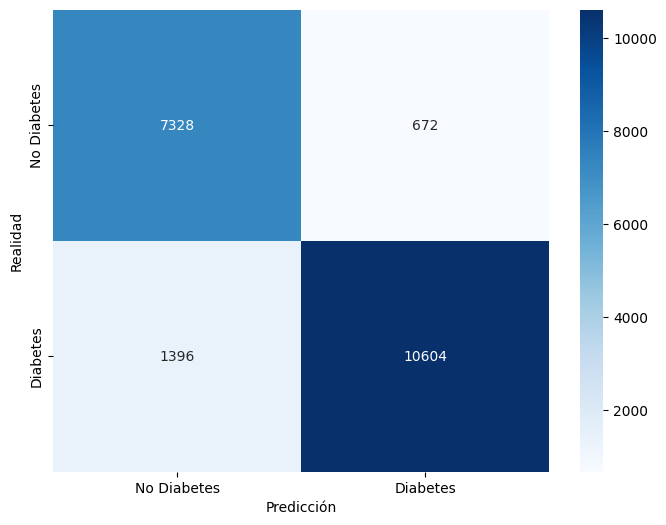

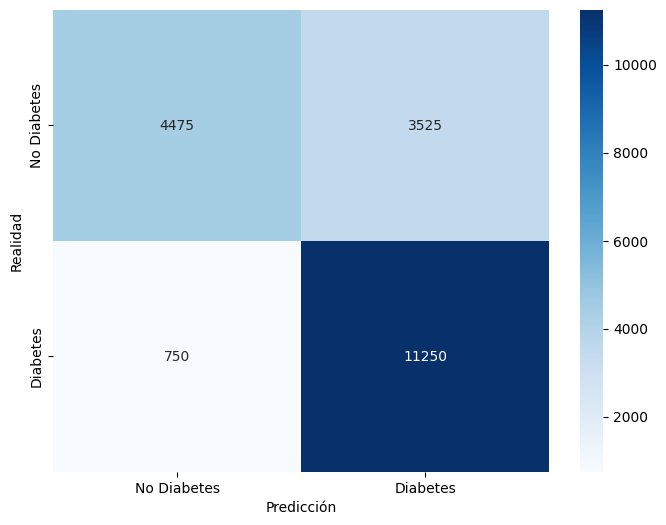

In [ ]:
prob_pos = best_forest.predict_proba(X_test_A_p)[:, 1]
y_pred_ajustado_3 = (prob_pos >= 0.3).astype(int)
matriz(y_test_A, y_pred_ajustado_3)
y_pred_ajustado_2 = (prob_pos >= 0.2).astype(int)
matriz(y_test_A, y_pred_ajustado_2)

In [ ]:
print(classification_report(y_test_A, y_pred_ajustado_2))
print(classification_report(y_test_A, y_pred_ajustado_3))

              precision    recall  f1-score   support

           0       0.86      0.56      0.68      8000
           1       0.76      0.94      0.84     12000

    accuracy                           0.79     20000
   macro avg       0.81      0.75      0.76     20000
weighted avg       0.80      0.79      0.77     20000

              precision    recall  f1-score   support

           0       0.84      0.92      0.88      8000
           1       0.94      0.88      0.91     12000

    accuracy                           0.90     20000
   macro avg       0.89      0.90      0.89     20000
weighted avg       0.90      0.90      0.90     20000



In [ ]:
comparativa = []
comparativa.append(metricas("RF Umbral 0.5", y_test_A, y_pred_best_forest))
comparativa.append(metricas("RF Umbral 0.3", y_test_A, y_pred_ajustado_3))
comparativa.append(metricas("RF Umbral 0.2", y_test_A, y_pred_ajustado_2))

df_comparativo = pd.DataFrame(comparativa)
print(df_comparativo)

          Modelo  Accuracy  Precision (C1)  Recall (C1)  F1-Score (C1)
0  RF Umbral 0.5   0.91980        0.999808     0.866500       0.928393
1  RF Umbral 0.3   0.89660        0.940404     0.883667       0.911153
2  RF Umbral 0.2   0.78625        0.761421     0.937500       0.840336


Aunque dentro del diagnóstico, los falsos negativos sean más peligrosos que los positivos, hemos considerado dejar el umbral en un 0.3. Con un menor umbral, se consiguen mitigar los falsos negativos a costa de los falsos positivos y el empeoramiento de la precisión, el recall y el f1. Dentro del diagnóstico se busca detectar la mayor cantidad de casos de diabetes posibles (recall clase 1) sin generar una alarma innecesaria inmanejable (precisión clase 1).

## Regresión Logística
https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html  

Algoritmo de aprendizaje supervisado para la clasificación binaria en la logística binomial (varios tipos según las clases). Calcula la probabilidad de que un input pertenezca a una clase dada.

In [ ]:
#Entrenamiento
logreg = LogisticRegression(max_iter=1000, random_state=0)
logreg.fit(X_train_A_p, y_train_A) #se aplica el Scaler
y_pred_A_logreg = logreg.predict(X_test_A_p)

In [ ]:
print(classification_report(y_test_A,y_pred_A_logreg))

              precision    recall  f1-score   support

           0       0.84      0.81      0.82      8000
           1       0.88      0.90      0.89     12000

    accuracy                           0.86     20000
   macro avg       0.86      0.85      0.85     20000
weighted avg       0.86      0.86      0.86     20000



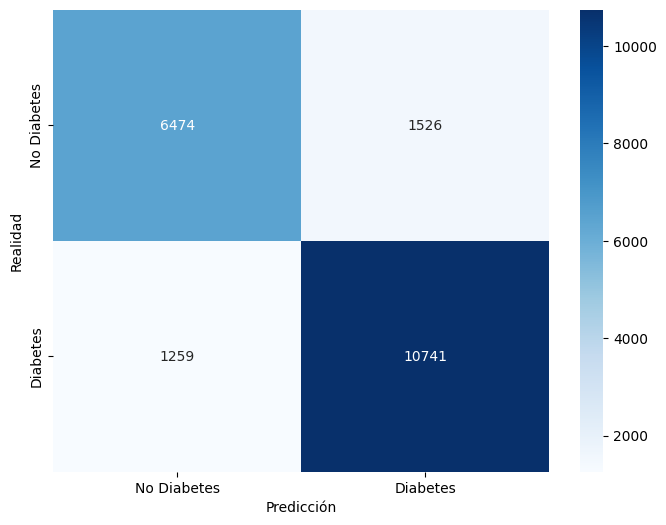

In [ ]:
matriz(y_test_A, y_pred_A_logreg)

## Árbol de Decisión

In [ ]:
arbol = DecisionTreeClassifier(max_depth=5, random_state=42)

arbol.fit(X_train_A_p, y_train_A)


DecisionTreeClassifier(max_depth=5, random_state=42)

In [ ]:
y_pred_arbol = arbol.predict(X_test_A_p)

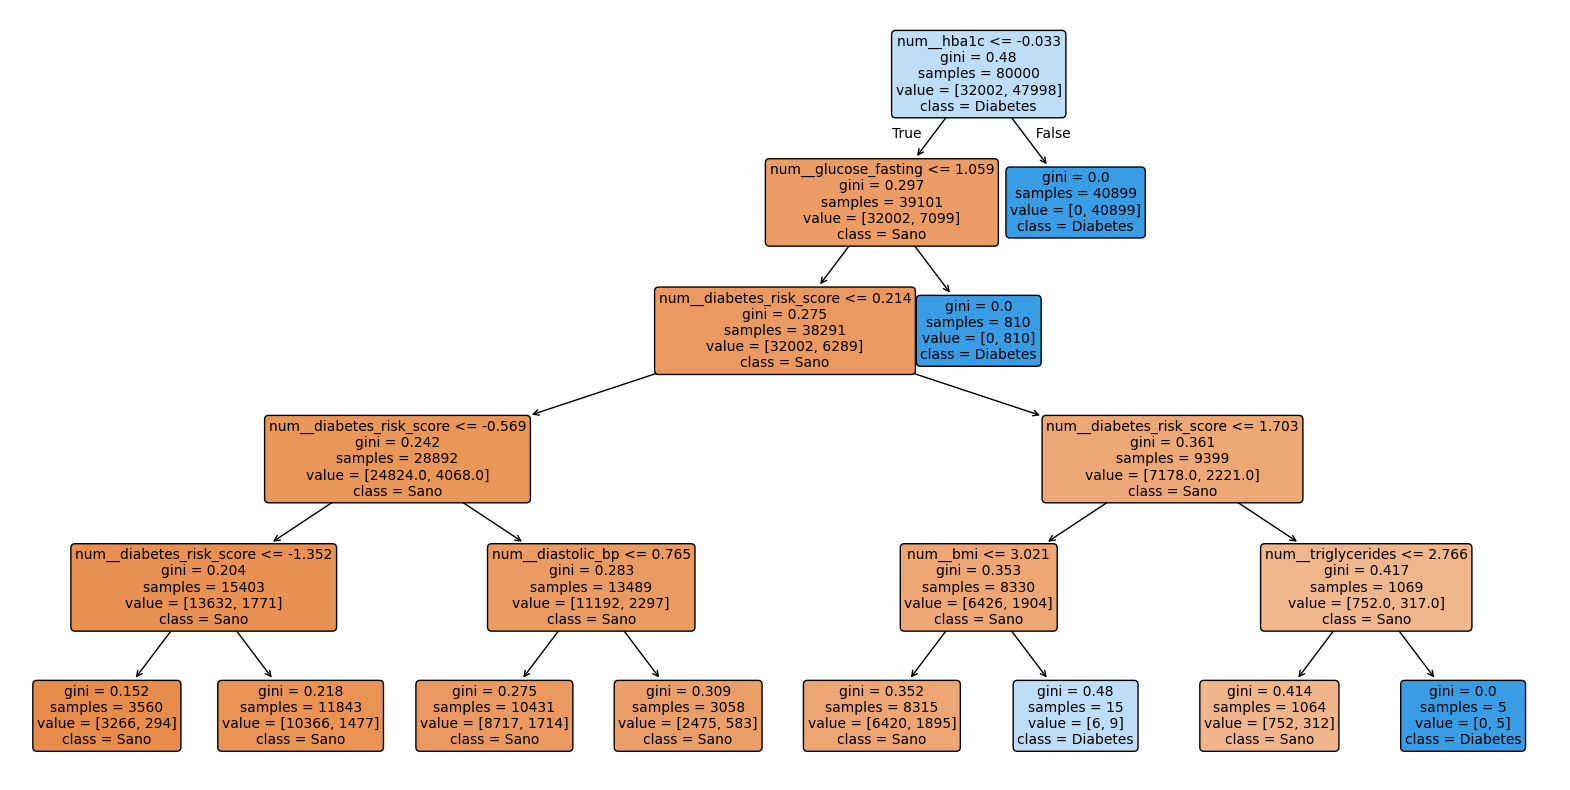

In [ ]:
plt.figure(figsize=(20,10))
plot_tree(arbol,
          feature_names=feature_names_A,
          class_names=['Sano', 'Diabetes'],
          filled=True,
          rounded=True,
          fontsize=10)
plt.show()

## Comparación entre modelos

In [ ]:
comparacion = []
comparacion.append(metricas("Regresión Logística", y_test_A, y_pred_A_logreg))
comparacion.append(metricas("Random Forest", y_test_A, y_pred_ajustado_3))
comparacion.append(metricas("Árbol de decisión", y_test_A, y_pred_arbol))
df_comparacion = pd.DataFrame(comparacion)
print(df_comparacion)

                Modelo  Accuracy  Precision (C1)  Recall (C1)  F1-Score (C1)
0  Regresión Logística   0.86075        0.875601     0.895083       0.885235
1        Random Forest   0.89660        0.940404     0.883667       0.911153
2    Árbol de decisión   0.91965        0.999136     0.866833       0.928294


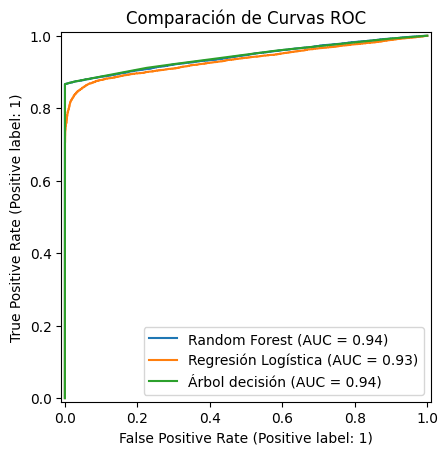

In [ ]:
fig, ax = plt.subplots()
RocCurveDisplay.from_estimator(best_forest, X_test_A_p, y_test_A, ax=ax, name='Random Forest')
RocCurveDisplay.from_estimator(logreg, X_test_A_p, y_test_A, ax=ax, name='Regresión Logística')
RocCurveDisplay.from_estimator(arbol, X_test_A_p, y_test_A, ax=ax, name='Árbol decisión')
plt.title("Comparación de Curvas ROC")
plt.show()

Aunque Random Forest suele tener mejores resultados que el Árbol de Decisión, en este caso este tuvo una precisión cercana a perfecta. Esto vuelve a sugerir que las glucosas actúan como fugas de datos.

In [ ]:
metricas_cv = ['accuracy', 'precision', 'recall', 'f1']
resultados_cv = cross_validate(best_forest, X_train_A_p, y_train_A, cv=5, scoring=metricas_cv)

resumen_cv = {metrica: resultados_cv[f'test_{metrica}'].mean() for metrica in metricas_cv}
print("Validación Cruzada (Promedios):")
print(resumen_cv)

Validación Cruzada (Promedios):
{'accuracy': np.float64(0.9213125), 'precision': np.float64(0.9996883082648387), 'recall': np.float64(0.8691195024655345), 'f1': np.float64(0.929841475395358)}


Los resultados de la validación cruzada coinciden con los resultados anteriores, por lo tanto, el modelo ha aprendido los patrones generales.

Tiene una precisión cercana al 100%, es decir, que el modelo no ha realizado casi ningún error. Esto se puede deber a que las variables de la glucosa son determinantes y que el modelo ha memorizado la regla.   

El modelo es capaz de detectar a 87 de cada 100 personas enfermas. Además, tiene un f1 mayor al 0.9, es decir, que es un modelo muy confiable con un equilibrio de alto nivel. Además, tiene una alta exactitud.

# Modelo C: Predicción de Riesgo

## Random Forest

In [ ]:
#Entrenamiento del modelo (100 árboles de decisión)
forestC = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
forestC.fit(X_train_C_p, y_train_C)
y_pred_C_forest = forestC.predict(X_test_C_p)

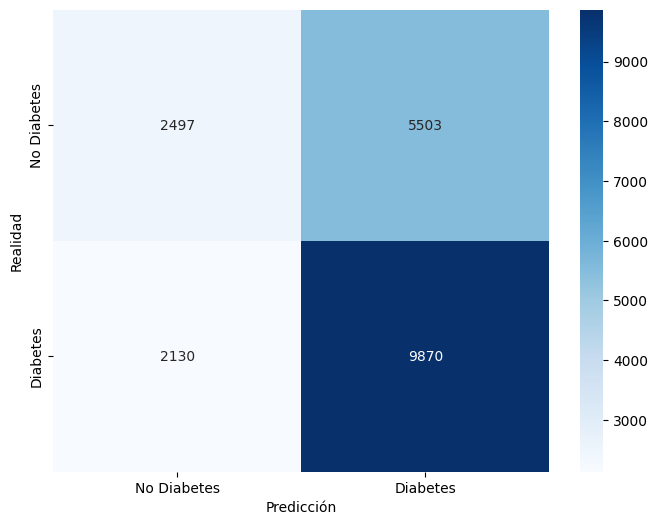

In [ ]:
matriz(y_test_C, y_pred_C_forest)

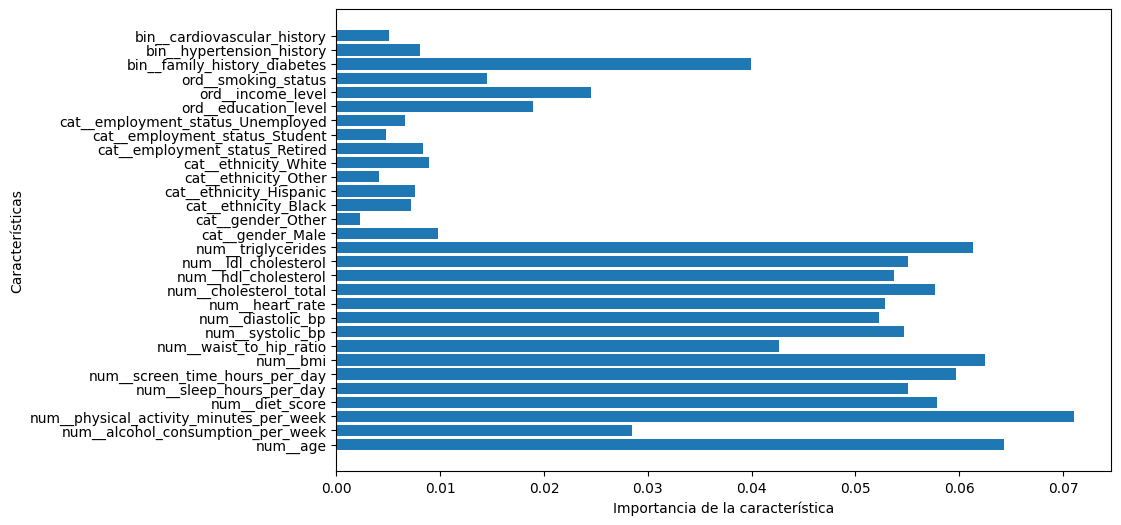

In [ ]:
feature_names = pipeline_preprocess_C.named_steps['preprocessor'].get_feature_names_out()

feature_importances_C = forestC.feature_importances_

plt.figure(figsize=(10, 6))
plt.barh(feature_names, feature_importances_C)
plt.xlabel('Importancia de la característica')
plt.ylabel('Características')
plt.show()

In [ ]:
print(classification_report(y_test_C, y_pred_C_forest))

              precision    recall  f1-score   support

           0       0.54      0.31      0.40      8000
           1       0.64      0.82      0.72     12000

    accuracy                           0.62     20000
   macro avg       0.59      0.57      0.56     20000
weighted avg       0.60      0.62      0.59     20000



El estilo de vida por sí solo no es un predictor tan infalible como la glucosa para el diagnósitco, lo que explica la caída de una precisión del 90% al 60%. Además, este modelo tiene un bajo recall en la clase 0 (0.31), pero un alto recall de clase 1 (0.82). Esto quiere decir que hay bastantes falsos positivos.


La característica más importante pasa a la actividad física, seguido de la edad y del IMC. Esto tiene sentido según la teoría del tipo 2 que vimos en el EDA. También tienen bastante importancia los lípidos (triglicéridos y colesterol).   

Una manera de solucionar esto es ajustar el umbral para que sea más conservador en el diagnóstico para bajar los falsos positivos.

In [ ]:
# Obtener las probabilidades de la clase 1 (Diabetes)
prob_pos_C = forestC.predict_proba(X_test_C_p)[:, 1]

nuevo_umbral = 0.6
y_pred_C_ajustado = (prob_pos_C >= nuevo_umbral).astype(int)

print(classification_report(y_test_C, y_pred_C_ajustado))

              precision    recall  f1-score   support

           0       0.50      0.61      0.55      8000
           1       0.69      0.59      0.64     12000

    accuracy                           0.60     20000
   macro avg       0.60      0.60      0.59     20000
weighted avg       0.62      0.60      0.60     20000



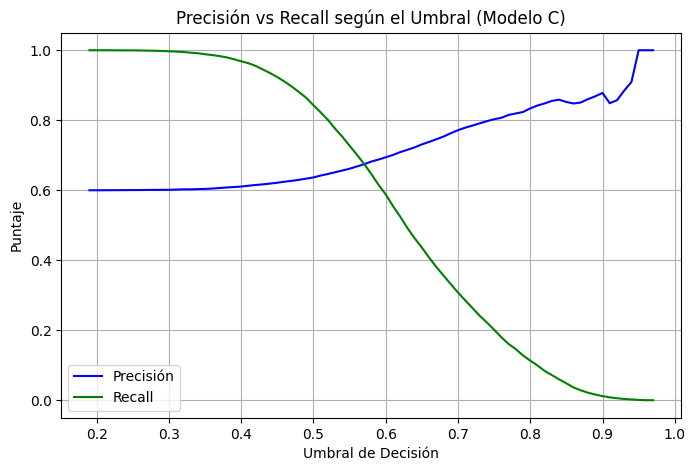

In [ ]:
precision, recall, thresholds = precision_recall_curve(y_test_C, prob_pos_C)

plt.figure(figsize=(8, 5))
plt.plot(thresholds, precision[:-1], label="Precisión", color="blue")
plt.plot(thresholds, recall[:-1], label="Recall", color="green")
plt.xlabel("Umbral de Decisión")
plt.ylabel("Puntaje")
plt.title("Precisión vs Recall según el Umbral (Modelo C)")
plt.legend()
plt.grid(True)
plt.show()

Las curvas se cruzan en el 0.57. Es decir, para que el modelo esté balanceado (mismo número de positivos que de negativos) el umbral debe de ser ese. Sin embargo, dentro de un modelo de prevención, es mejor identificar a los posibles riesgos que ignorar a alguien que es posible que desarrolle la enfermedad. Por lo tanto, hemos decidido aplicarlo al 0.49. Esto quiere decir que a partir del 50% de probabilidad de tener diabetes, el sistema indica que lo tiene.

**Aclaración**: Esta regla se ha seguido para ambos modelos al desplegar la aplicación.  

El modelo ahora tiene casi la misma capacidad de distinguir una persona sana que una persona con diabetes y ya no está sesgado por ninguna de las dos categorías. Al elevar el umbral más, conseguiríamos menos falsos positivos, pero más falsos negativos.

La conclusión es que al quitar la glucosa, los factores de riesgo no pueden ser utilizados como una herramienta de diagnóstico por sí sola.

In [ ]:
forestC = RandomForestClassifier(random_state=42)

param_distC = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'class_weight': ['balanced', None]
}

random_searchC = RandomizedSearchCV(
    estimator=forestC,
    param_distributions=param_distC,
    n_iter=10,
    cv=3,
    n_jobs=-1,
    scoring='f1',
    verbose=2,
    random_state=42
)

random_searchC.fit(X_train_C_p, y_train_C)

print(f"\nMejores parámetros encontrados: {random_searchC.best_params_}")

Fitting 3 folds for each of 10 candidates, totalling 30 fits

Mejores parámetros encontrados: {'n_estimators': 200, 'min_samples_split': 5, 'max_depth': 10, 'class_weight': None}


In [ ]:
best_forestC = RandomForestClassifier(**random_searchC.best_params_, random_state=42)
best_forestC.fit(X_train_C_p, y_train_C)

y_pred_best_forestC = best_forestC.predict(X_test_C_p)

In [ ]:
print(classification_report(y_test_C, y_pred_best_forestC))

              precision    recall  f1-score   support

           0       0.57      0.25      0.35      8000
           1       0.64      0.87      0.74     12000

    accuracy                           0.62     20000
   macro avg       0.60      0.56      0.54     20000
weighted avg       0.61      0.62      0.58     20000



## Regresión Logística

In [ ]:
#Entrenamiento
logregC = LogisticRegression(max_iter=1000, random_state=0, class_weight='balanced')
logregC.fit(X_train_C_p, y_train_C)
y_pred_C_logreg = logregC.predict(X_test_C_p)

              precision    recall  f1-score   support

           0       0.50      0.66      0.57      8000
           1       0.72      0.56      0.63     12000

    accuracy                           0.60     20000
   macro avg       0.61      0.61      0.60     20000
weighted avg       0.63      0.60      0.61     20000



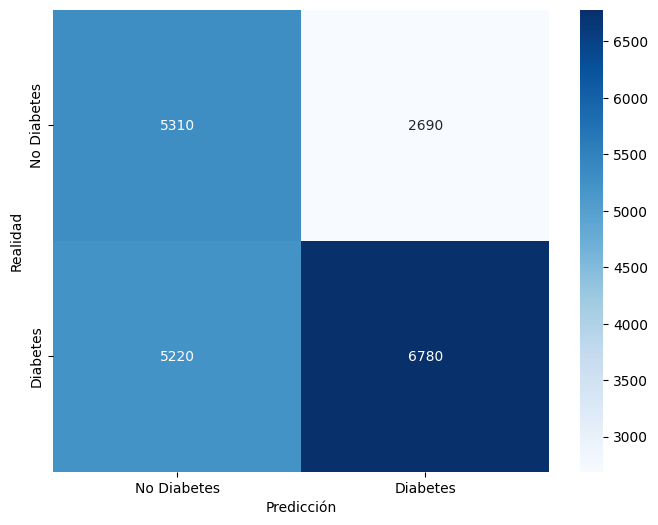

In [ ]:
print(classification_report(y_test_C, y_pred_C_logreg))
matriz(y_test_C, y_pred_C_logreg)

## Árbol de decisión

In [ ]:
arbolC = DecisionTreeClassifier(max_depth=5, random_state=42)

arbolC.fit(X_train_C_p, y_train_C)

y_pred_arbol_C = arbolC.predict(X_test_C_p)

In [ ]:
print(classification_report(y_test_C, y_pred_arbol_C))

              precision    recall  f1-score   support

           0       0.55      0.37      0.44      8000
           1       0.65      0.80      0.72     12000

    accuracy                           0.62     20000
   macro avg       0.60      0.58      0.58     20000
weighted avg       0.61      0.62      0.61     20000



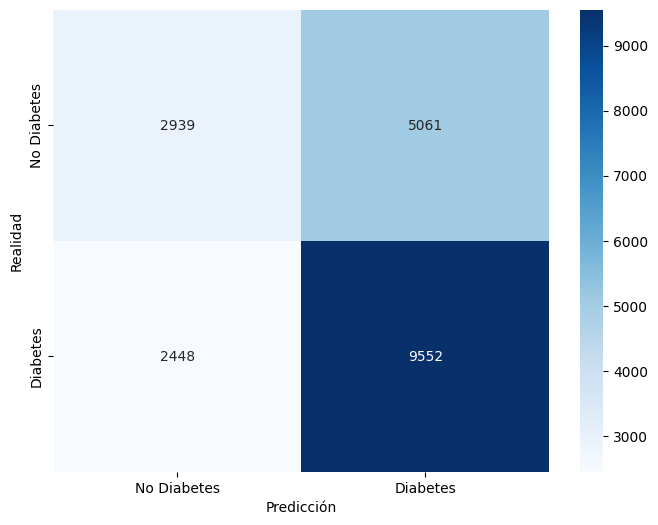

In [ ]:
matriz(y_test_C, y_pred_arbol_C)

## Validación cruzada
LightGBM, XGBoost y CatBoost

In [ ]:
X_train_cv = X_train_C_p
X_test_cv = X_test_C_p
y_train_cv = y_train_C.values

n_splits = 5
kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

oof_lgb, oof_xgb, oof_cat = [np.zeros(len(X_train_cv)) for _ in range(3)]
pred_lgb, pred_xgb, pred_cat = [np.zeros(len(X_test_cv)) for _ in range(3)]

for fold, (train_idx, val_idx) in enumerate(kf.split(X_train_cv, y_train_cv)):
    X_tr, X_val = X_train_cv[train_idx], X_train_cv[val_idx]
    y_tr, y_val = y_train_cv[train_idx], y_train_cv[val_idx]

    # XGBoost
    m_xgb = XGBClassifier(n_estimators=500, learning_rate=0.05, max_depth=6,
                          eval_metric='logloss', random_state=42)
    m_xgb.fit(X_tr, y_tr, eval_set=[(X_val, y_val)], verbose=False)
    oof_xgb[val_idx] = m_xgb.predict_proba(X_val)[:, 1]
    pred_xgb += m_xgb.predict_proba(X_test_cv)[:, 1] / n_splits

    # LightGBM
    m_lgb = lgb.LGBMClassifier(n_estimators=500, learning_rate=0.05, random_state=42, verbose=-1)
    m_lgb.fit(X_tr, y_tr, eval_set=[(X_val, y_val)],
              callbacks=[lgb.early_stopping(25)])
    oof_lgb[val_idx] = m_lgb.predict_proba(X_val)[:, 1]
    pred_lgb += m_lgb.predict_proba(X_test_cv)[:, 1] / n_splits

    #CatBoost
    m_cat = CatBoostClassifier(iterations=500, learning_rate=0.05, depth=6,
                               random_state=42, verbose=0, early_stopping_rounds=25)
    m_cat.fit(X_tr, y_tr, eval_set=(X_val, y_val))
    oof_cat[val_idx] = m_cat.predict_proba(X_val)[:, 1]
    pred_cat += m_cat.predict_proba(X_test_cv)[:, 1] / n_splits

    print(f"Fold {fold+1} completado.")

Training until validation scores don't improve for 25 rounds
Early stopping, best iteration is:
[65]	valid_0's binary_logloss: 0.634484


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Fold 1 completado.
Training until validation scores don't improve for 25 rounds
Early stopping, best iteration is:
[80]	valid_0's binary_logloss: 0.631211


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Fold 2 completado.
Training until validation scores don't improve for 25 rounds
Early stopping, best iteration is:
[102]	valid_0's binary_logloss: 0.633647


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Fold 3 completado.
Training until validation scores don't improve for 25 rounds
Early stopping, best iteration is:
[67]	valid_0's binary_logloss: 0.636425


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Fold 4 completado.
Training until validation scores don't improve for 25 rounds
Early stopping, best iteration is:
[81]	valid_0's binary_logloss: 0.632405


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Fold 5 completado.


In [ ]:
print("\nResultados (AUC ROC):")
print(f"XGBoost OOF AUC: {roc_auc_score(y_train_cv, oof_xgb):.4f}")
print(f"LightGBM OOF AUC: {roc_auc_score(y_train_cv, oof_lgb):.4f}")
print(f"CatBoost OOF AUC: {roc_auc_score(y_train_cv, oof_cat):.4f}")

final_oof = (oof_xgb + oof_lgb + oof_cat) / 3
print(f"Ensemble OOF AUC: {roc_auc_score(y_train_cv, final_oof):.4f}")


Resultados (AUC ROC):
XGBoost OOF AUC: 0.6495
LightGBM OOF AUC: 0.6591
CatBoost OOF AUC: 0.6604
Ensemble OOF AUC: 0.6584


/tmp/ipython-input-1506399459.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=df_imp, palette='viridis')


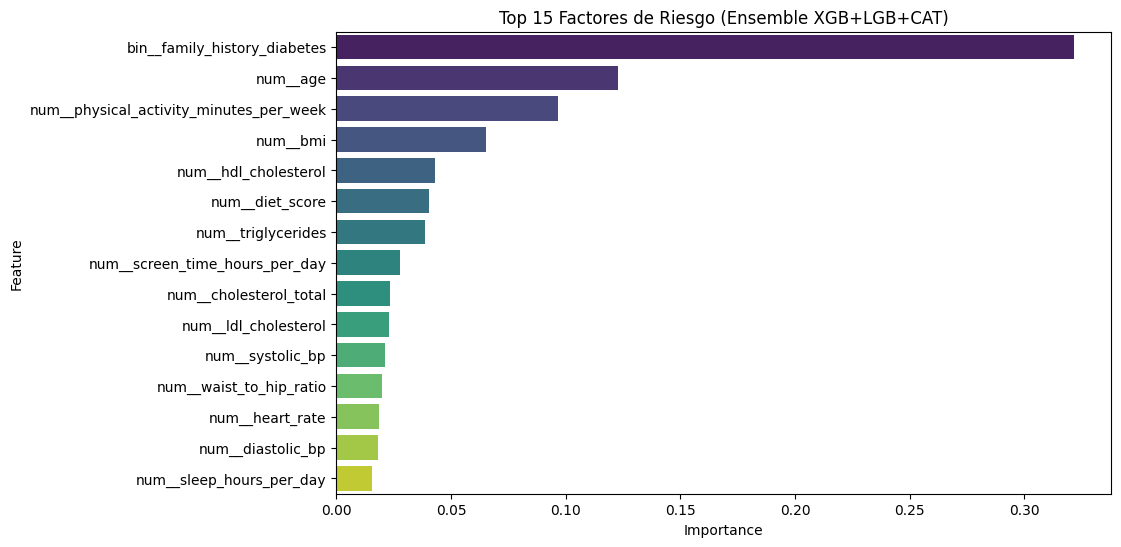

In [ ]:
feature_names = pipeline_preprocess_C.named_steps['preprocessor'].get_feature_names_out()

feat_imp_xgb = m_xgb.feature_importances_ / m_xgb.feature_importances_.sum()
feat_imp_lgb = m_lgb.feature_importances_ / m_lgb.feature_importances_.sum()
feat_imp_cat = m_cat.get_feature_importance() / m_cat.get_feature_importance().sum()

final_importance = (feat_imp_xgb + feat_imp_lgb + feat_imp_cat) / 3

df_imp = pd.DataFrame({'Feature': feature_names, 'Importance': final_importance})
df_imp = df_imp.sort_values(by='Importance', ascending=False).head(15)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=df_imp, palette='viridis')
plt.title('Top 15 Factores de Riesgo')
plt.show()

              precision    recall  f1-score   support

           0       0.50      0.66      0.57      8000
           1       0.71      0.56      0.63     12000

    accuracy                           0.60     20000
   macro avg       0.61      0.61      0.60     20000
weighted avg       0.63      0.60      0.61     20000



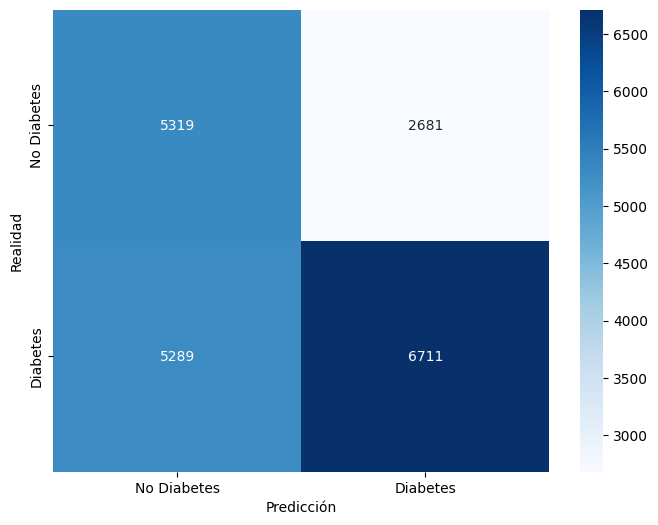

In [ ]:
umbral_optimo = 0.6
y_pred_ensemble = (pred_cat >= umbral_optimo).astype(int)

print(classification_report(y_test_C, y_pred_ensemble))

matriz(y_test_C, y_pred_ensemble)

## Comparación entre modelos


In [ ]:
comparacionC = []
comparacionC.append(metricas("Regresión Logística", y_test_C, y_pred_C_logreg))
comparacionC.append(metricas("Random Forest", y_test_C, y_pred_C_ajustado))
comparacionC.append(metricas("Árbol de decisión", y_test_C, y_pred_arbol_C))
df_comparacionC = pd.DataFrame(comparacionC)
print(df_comparacionC)

                Modelo  Accuracy  Precision (C1)  Recall (C1)  F1-Score (C1)
0  Regresión Logística   0.60450        0.715945     0.565000       0.631579
1        Random Forest   0.59740        0.694177     0.588083       0.636741
2    Árbol de decisión   0.62455        0.653665     0.796000       0.717845


La regresión logística tiene el mejor F1-score y el mejor Recall. Esto sugiere que el riesgo de diabetes es relativamente lineal o que los otros dos modelos, basados en árboles, al quitarles la glucosa solo pueden encontrar combinaciones que no se repiten en el test (sobreajuste).

El Random Forest tiene la precisión más alta, pero el Recall más bajo. Eso quiere decir que tiene muchos falsos negativos. Tiene una buena precisión puntual, pero mala discriminación global.

El Árbol de decisión se encuentra en un punto medio entre ambos.

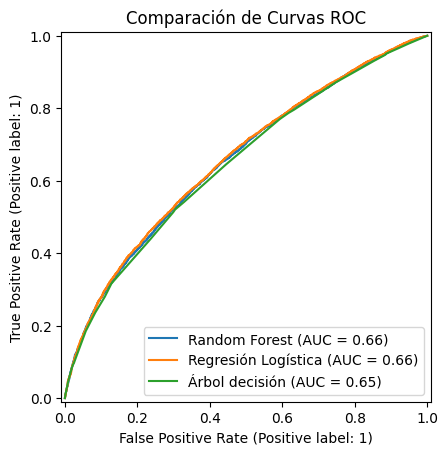

In [ ]:
fig, ax = plt.subplots()
RocCurveDisplay.from_estimator(best_forestC, X_test_C_p, y_test_C, ax=ax, name='Random Forest')
RocCurveDisplay.from_estimator(logregC, X_test_C_p, y_test_C, ax=ax, name='Regresión Logística')
RocCurveDisplay.from_estimator(arbolC, X_test_C_p, y_test_C, ax=ax, name='Árbol decisión')
plt.title("Comparación de Curvas ROC de Modelo C")
plt.show()

Los AUC de los tres modelos están alrededor del 0.65, es decir, que es mejor que el azar, pero ninguno de los tres es un modelo fuerte.

# Aplicación web
Se ha creado una aplicación web que contiene ambos modelos. Para ello, se exportan los modelos en un archivo .joblib.

In [ ]:
joblib.dump(best_forest, 'model_A_forest.joblib')
joblib.dump(pipeline_preprocess, 'preprocessor_A.joblib')

['preprocessor_A.joblib']

In [ ]:
joblib.dump(best_forestC, 'model_C_risk.joblib')
joblib.dump(pipeline_preprocess_C, 'preprocessor_C.joblib')

['preprocessor_C.joblib']